import newspaper
from newspaper import *
from mongoengine import *
from lib import *

connect(DATABASE_NAME)
alltokens = get_content_article()
tagged = []
for art_token in alltokens:
    tagged.append(tagText(art_token))

In [1]:
import nltk
import sys
sys.path.append('rake/')
from rake import rake as rk
import operator

In [6]:
stoppath = "rake/StopwordsFrench.txt"
rake_object = rk.Rake(stoppath,5,3,1)
text = "Le bruit a couru dans la journée : EutelSat, un des fournisseurs de Canal + Réunion, l'a menacé lundi de suspendre sa diffusion à La Réunion pour cause d'impayés depuis plusieurs mois. Aujourd'hui, les choses sont rentrées dans l'ordre, selon la direction qui annonce avoir payé son prestataire. Contactée, elle assure qu'il n'y aura pas de coupure des chaînes à partir de jeudi. Pas d'inquiétude donc pour les 450 000 abonnés de Canal Sat/Canal + dans l'océan indien. Plus d'informations dans votre édition de demain."

result = rake_object.run(text)
for elem,i in result:
    print elem,': ',i

AttributeError: 'list' object has no attribute 'keys'

In [3]:
from mongoengine import *
from lib import *
from document import NewArticle
import nltk
import sys
sys.path.append('rake/')
from rake import rake as rk
import operator

connect(DATABASE_NAME)
stoppath = "rake/StopwordsFrench.txt"
rake_object = rk.Rake(stoppath,5,2,1)

#for article,ident in [(elms.text,elms.id) for elms in NewArticle.objects]:
for elms in NewArticle.objects:
    result = rake_object.run(elms.text)
    elms.update(set__keywords=','.join([words for words,score in result]))
print('DONE!')

DONE!


In [4]:
def hierarchical(matrix, label):
    import matplotlib
    #matplotlib.use('agg')
    import matplotlib.pyplot as plt
    from scipy.cluster.hierarchy import ward, dendrogram, linkage
    from scipy.cluster.hierarchy import cophenet
    from scipy.spatial.distance import pdist


    linkage_matrix = linkage(matrix, 'ward')
    c, coph_dists = cophenet(linkage_matrix, pdist(matrix))

    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('articles')
    plt.ylabel('distance')

    fig, ax = plt.subplots(figsize=(15, 20))
    ax = dendrogram(
        linkage_matrix,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        orientation="right",
        labels=label
    )
    plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

    plt.tight_layout() #show plot with tight layout

    plt.show()

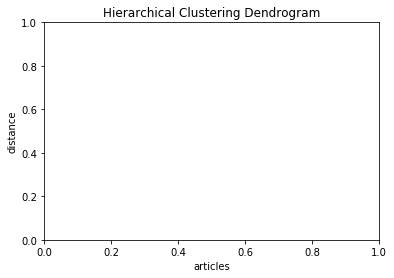

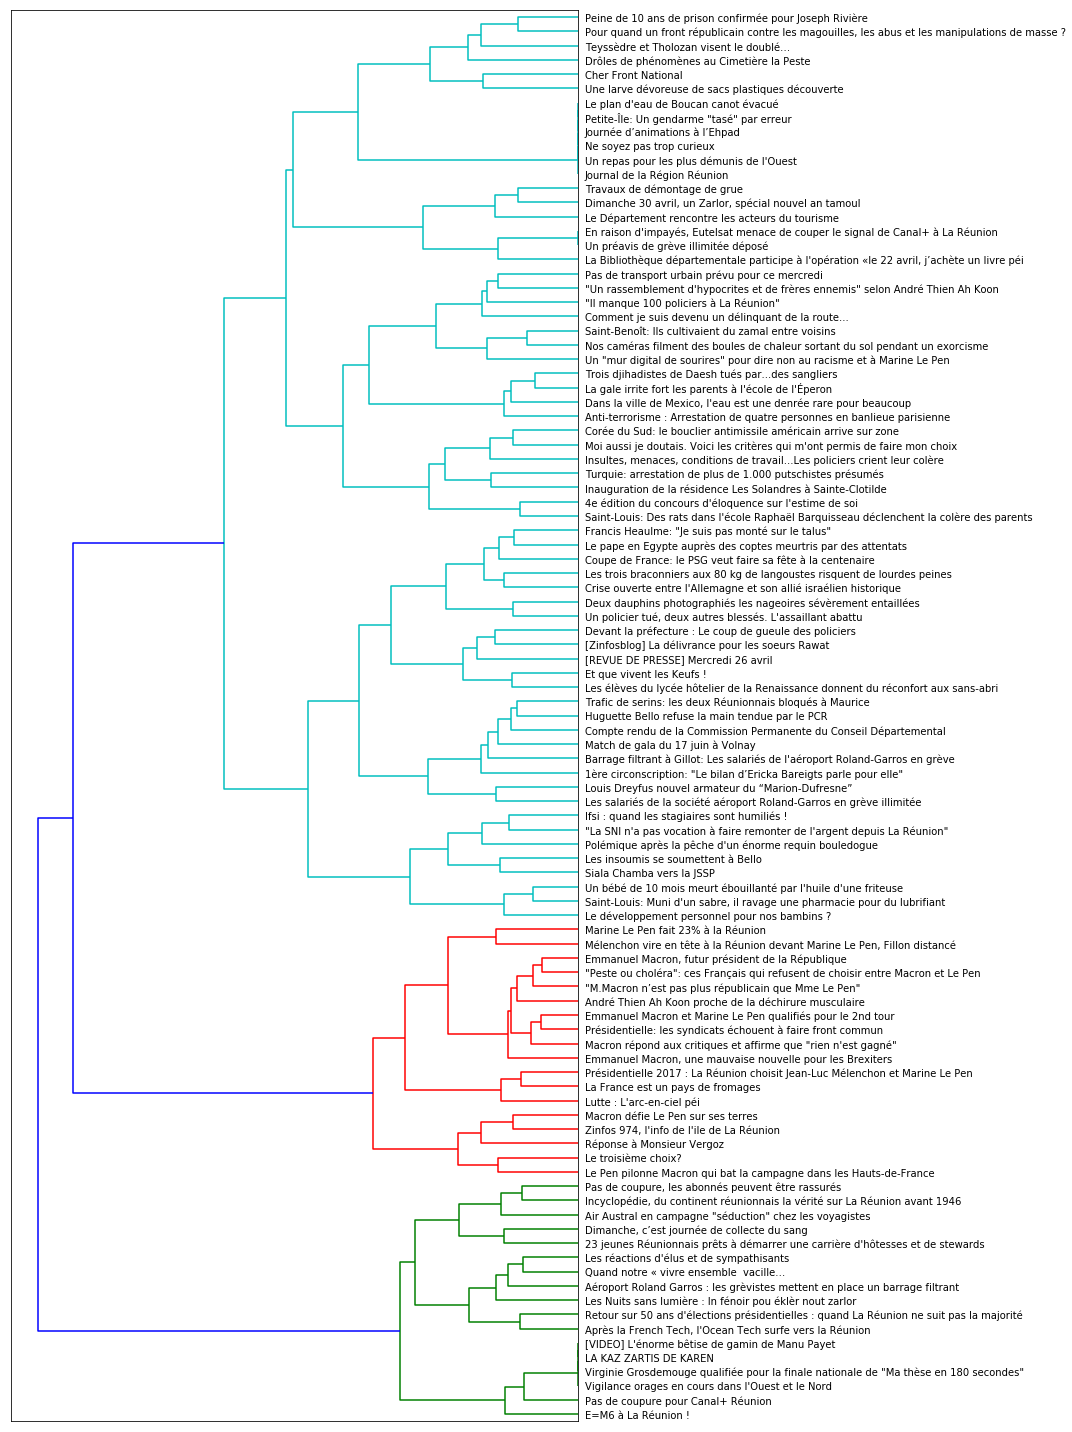

In [20]:
import nltk
from mongoengine import *
from document import *
from lib import *
from algo_clustering import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import cluster
from operator import itemgetter
from itertools import groupby
import logging
from datetime import datetime
import time

log_name = datetime.now().strftime("%Y%m%d_%H%M")
logging.basicConfig(filename='log/clusters/' + log_name + '.log',
                    level=logging.DEBUG,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    datefmt='%d-%m-%Y %I:%M:%S %p')

stopwords = nltk.corpus.stopwords.words('french')
stopwords += nltk.corpus.stopwords.words('english')

"""Retrieve all contents for the clustering"""
content = get_content_article()
logging.info("Retrieve all articles for the classification")

"""tf-idf representation"""
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2,stop_words=stopwords,
                                    use_idf=True,ngram_range=(1,3))
                                    #,tokenizer=tokenize_only)
tfidf_matrix = tfidf_vectorizer.fit_transform(content.values())
dist = 1 - cosine_similarity(tfidf_matrix)
"""Test of Hierarchical algorithm"""
titre = []
for valeur in content.keys():
    titre += [ atcl.title for atcl in NewArticle.objects(id__exact=valeur)]
hierarchical(dist,titre)

In [18]:
import nltk
from mongoengine import *
from document import *
from lib import *
from algo_clustering import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import cluster
from operator import itemgetter
from itertools import groupby
import logging
from datetime import datetime
import time

connect(DATABASE_NAME)
content = get_content_article()
titre = []
for valeur in content.keys():
    titre += [ atcl.title for atcl in NewArticle.objects(id__exact=valeur)]

In [19]:
print(titre)

[u'Huguette Bello refuse la main tendue par le PCR', u'Anti-terrorisme : Arrestation de quatre personnes en banlieue parisienne', u'Le Pen pilonne Macron qui bat la campagne dans les Hauts-de-France', u'E=M6 \xe0 La R\xe9union !', u"Lutte : L'arc-en-ciel p\xe9i", u'Siala Chamba vers la JSSP', u'Inauguration de la r\xe9sidence Les Solandres \xe0 Sainte-Clotilde', u'Pour quand un front r\xe9publicain contre les magouilles, les abus et les manipulations de masse ?', u"Vigilance orages en cours dans l'Ouest et le Nord", u'Dimanche 30 avril, un Zarlor, sp\xe9cial nouvel an tamoul', u'Insultes, menaces, conditions de travail...Les policiers crient leur col\xe8re', u"Pol\xe9mique apr\xe8s la p\xeache d'un \xe9norme requin bouledogue", u'Les salari\xe9s de la soci\xe9t\xe9 a\xe9roport Roland-Garros en gr\xe8ve illimit\xe9e', u'Virginie Grosdemouge qualifi\xe9e pour la finale nationale de "Ma th\xe8se en 180 secondes"', u'"La SNI n\'a pas vocation \xe0 faire remonter de l\'argent depuis La R\xe

In [16]:
for iiii in a:
    print(iiii.title)

Pour quand un front républicain contre les magouilles, les abus et les manipulations de masse ?
